In [1]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')

In [3]:
print("\n", train.head())


                  id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [4]:
print('\n', train['comment_text'][0])
print('\n', train['comment_text'][2])


 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

 Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.


In [5]:
lens = train.comment_text.str.len()
print('\n', lens.mean(), lens.std(), lens.max())


 394.0732213246768 590.7202819048919 5000


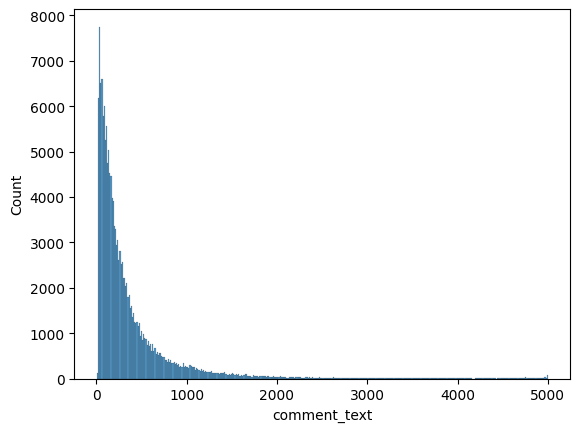

In [6]:
plt.figure()
sns.histplot(lens)
plt.show()

In [7]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1 - train[label_cols].max(axis = 1)
print("\n", train.describe())


                toxic   severe_toxic        obscene         threat  \
count  159571.000000  159571.000000  159571.000000  159571.000000   
mean        0.095844       0.009996       0.052948       0.002996   
std         0.294379       0.099477       0.223931       0.054650   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              insult  identity_hate           none  
count  159571.000000  159571.000000  159571.000000  
mean        0.049364       0.008805       0.898321  
std         0.216627       0.093420       0.302226  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       1.000000  
50%         0.000000       0.000000       1.000000  
75%  

In [8]:
print("\n", len(train), len(test))


 159571 153164


In [9]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace = True)
test[COMMENT].fillna("unknown", inplace = True)

Building the model<br>
We'll start by creating a bag of words representation, as a term document matrix. We'll use ngrams, as suggested in the NBSVM paper.

In [10]:
import re, string
re_tok = re.compile(f'([{string.punctuation}""Â¨Â«Â»Â®Â´Â·ÂºÂ½Â¾Â¿Â¡Â§Â£â‚¤â€˜â€™])')
def tokenize(s) : return re_tok.sub(r' \1 ', s).split()

It turns out that using TF-IDF gives even better priors than the binarized features used in the paper. I don't think this has been mentioned in any paper before, but it improves leaderboard score from 0.59 to 0.55.

In [11]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range = (1, 2), tokenizer = tokenize, min_df = 3, max_df = 0.9, strip_accents = 'unicode', use_idf = 1, smooth_idf = 1, sublinear_tf = 1)
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [12]:
"max_df = 0.50 means 'ignore terms that appear in more than 50% of the documents'. min_df = 5 means 'ignore terms that appear in less than 5 documents'."

"max_df = 0.50 means 'ignore terms that appear in more than 50% of the documents'. min_df = 5 means 'ignore terms that appear in less than 5 documents'."

This creates a sparse matrix with only a small number of non-zero elements (stored elements in the representation below).

In [13]:
trn_term_doc, test_term_doc

(<159571x425941 sparse matrix of type '<class 'numpy.float64'>'
 	with 17760447 stored elements in Compressed Sparse Row format>,
 <153164x425941 sparse matrix of type '<class 'numpy.float64'>'
 	with 14752632 stored elements in Compressed Sparse Row format>)

In [14]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum() + 1)

In [15]:
x = trn_term_doc
test_x = test_term_doc

In [16]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1, y) / pr(0, y))
    m = LogisticRegression(C = 4)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [17]:
preds = np.zeros((len(test), len(label_cols)))

In [18]:
for i, j in enumerate(label_cols):
    print("\n", 'fit', j)
    m, r = get_mdl(train[j])
    preds[:, i] = m.predict_proba(test_x.multiply(r)) [:, 1]


 fit toxic

 fit severe_toxic

 fit obscene

 fit threat

 fit insult

 fit identity_hate
